# Жолковский Евгений

Будем ускорять работу алгоритма KMeans++, так как он самый трудоемкий

In [1]:
from math import sqrt
import numpy as np

### Используем sklearn только для создания кластеров:

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=10000, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=221)

### Настраиваем графики:

In [3]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

### Профалер:

In [4]:
from line_profiler import LineProfiler
def profile_print(func_to_call, *args):
    profiler = LineProfiler()
    profiler.add_function(func_to_call)
    profiler.runcall(func_to_call, *args)
    profiler.print_stats()

# Реализация  KMeans++ без использования Cython, Numba, но с использованием cdist из Scipy:

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.spatial.distance import cdist
class KMeans_cdist(BaseEstimator, ClassifierMixin): 
    
    def __init__(self, k=3, metric='euclidean', max_iter=100, random_state=0, eps=0.01):
    
        self.Nclusters = k #число кластеров
        self.Npoints = 1 #число точек в данных
        self.y = np.ones(1) #вектор принадлежности к классу
        self.metric = metric #метрика
        self.max_iter = max_iter #максимальное число итераций
        self.random_state = random_state #зернышко
        self.centroids = np.array((1)) #центроиды
        self.eps = eps #критерий остановки
        
    
    def fit(self, X):
        
        
        self.Npoints = X.shape[0] #число точек
        self.dim = X.shape[1]
        np.random.seed(self.random_state) #зернышко
        self.y.resize(self.Npoints) #вектор с предсказаниями
        self.centroids = np.zeros((self.Nclusters,self.dim)) #инициализируем нулями

        #случайное начальное распределение
        self.centroids = np.random.rand(self.Nclusters,self.dim) #координаты центроидов
       
        for j in xrange(self.max_iter):
            
            #сохраняем предыдущее значение
            centroids_prev = np.copy(self.centroids)
            
            #классифицируем
            self.y = np.argmin(cdist(X, self.centroids), axis=1)
            
            #перераспределяем центроиды 
            self.centroids = np.array([np.mean(X[self.y == i], axis=0) for i in range(self.Nclusters)])
            #проверяем сходимость
            if ((centroids_prev - self.centroids) ** 2).mean() < self.eps:
                break
                
    def predict(self, what='y'):
        
        #вернуть коорднаты центроидов
        if what == 'centroids':
            return self.centroids
        
        #вернуть метки кластеров для точек
        if what == 'y':
            return self.y
    

### KMeans:

100 loops, best of 3: 2.17 ms per loop


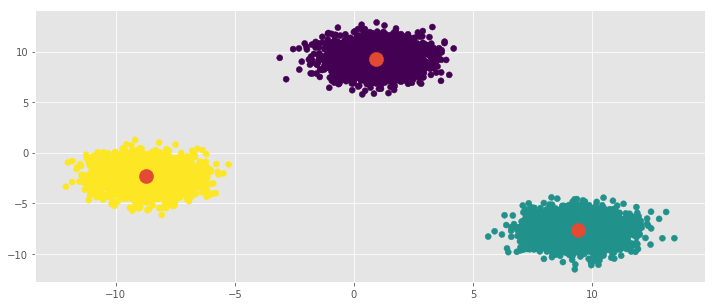

In [6]:
## Работоспособность KMeans
Kmeans_cdist = KMeans_cdist(k=3)
%timeit Kmeans_cdist.fit(X)
y_test_KMeans = Kmeans_cdist.predict(what='y')
C_test_KMeans = Kmeans_cdist.predict(what='centroids')


plt.scatter(X[:,0], X[:,1], c=y_test_KMeans)
plt.scatter(C_test_KMeans[:,0], C_test_KMeans[:,1], s=200)
plt.show()

### Профайлинг функции fit:

In [7]:
profile_print(Kmeans_cdist.fit, X)

Timer unit: 1e-06 s

Total time: 0.004747 s
File: <ipython-input-5-a911efd5d1bf>
Function: fit at line 17

Line #      Hits         Time  Per Hit   % Time  Line Contents
    17                                               def fit(self, X):
    18                                                   
    19                                                   
    20         1            4      4.0      0.1          self.Npoints = X.shape[0] #число точек
    21         1            3      3.0      0.1          self.dim = X.shape[1]
    22         1           13     13.0      0.3          np.random.seed(self.random_state) #зернышко
    23         1            7      7.0      0.1          self.y.resize(self.Npoints) #вектор с предсказаниями
    24         1            6      6.0      0.1          self.centroids = np.zeros((self.Nclusters,self.dim)) #инициализируем нулями
    25                                           
    26                                                   #случайное началь

# Реализация  KMeans++ без использования Cython, Numba, Scipy:

In [8]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KMeans_python(BaseEstimator, ClassifierMixin): 
    
    def __init__(self, k=3, metric='euclidean', max_iter=100, random_state=0, eps=0.01):
    
        self.Nclusters = k #число кластеров
        self.Npoints = 1 #число точек в данных
        self.y = np.ones(1) #вектор принадлежности к классу
        self.metric = metric #метрика
        self.max_iter = max_iter #максимальное число итераций
        self.random_state = random_state #зернышко
        self.centroids = np.array((1)) #центроиды
        self.eps = eps #критерий остановки
        
    #аналог cdist
    def dist_matrix(self, X, Y):
        return np.sqrt(((X[:,None, : ] - Y) ** 2).sum(-1))
    
    def fit(self, X):
        
        #и
        self.Npoints = X.shape[0] #число точек
        self.dim = X.shape[1]
        np.random.seed(self.random_state) #зернышко
        self.y.resize(self.Npoints) #iniя с предсказаниями
        self.centroids = np.zeros((self.Nclusters,self.dim)) #инициализируем нулями

        #случайное начальное распределение
        self.centroids = np.random.rand(self.Nclusters,self.dim) #координаты центроидов
       
        
        for j in xrange(self.max_iter):
            
            #сохраняем предыдущее значение
            centroids_prev = np.copy(self.centroids)
            
            #классифицируем
            self.y = np.argmin(self.dist_matrix(X, self.centroids), axis=1)
            
            #перераспределяем центроиды 
            #self.centroids = np.array([X[self.y == i].mean(axis=0) for i in range(self.Nclusters)])
            self.centroids = np.array([np.mean(X[self.y == i], axis=0) for i in range(self.Nclusters)])
            #проверяем сходимость
            if ((centroids_prev - self.centroids) ** 2).mean() < self.eps:
                break
                
    def predict(self, what='y'):
        
        #вернуть коорднаты центроидов
        if what == 'centroids':
            return self.centroids
        
        #вернуть метки кластеров для точек
        if what == 'y':
            return self.y
    

100 loops, best of 3: 4.86 ms per loop


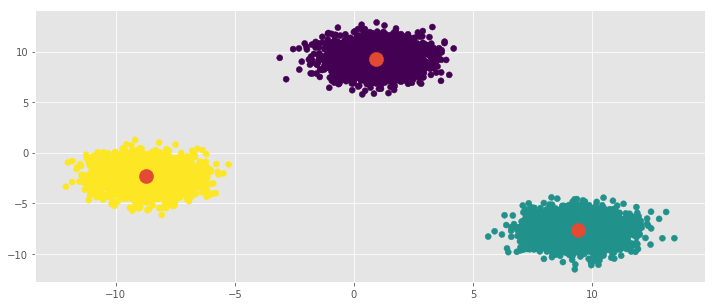

In [9]:
## Работоспособность KMeans
Kmeans_python = KMeans_python(k=3)
%timeit Kmeans_python.fit(X)
y_test_KMeans = Kmeans_python.predict(what='y')
C_test_KMeans = Kmeans_python.predict(what='centroids')


plt.scatter(X[:,0], X[:,1], c=y_test_KMeans)
plt.scatter(C_test_KMeans[:,0], C_test_KMeans[:,1], s=200)
plt.show()

### Профайлинг функции fit:

In [10]:
profile_print(Kmeans_python.fit, X)

Timer unit: 1e-06 s

Total time: 0.010583 s
File: <ipython-input-8-fb507cea2e6a>
Function: fit at line 20

Line #      Hits         Time  Per Hit   % Time  Line Contents
    20                                               def fit(self, X):
    21                                                   
    22                                                   #и
    23         1            8      8.0      0.1          self.Npoints = X.shape[0] #число точек
    24         1            3      3.0      0.0          self.dim = X.shape[1]
    25         1           18     18.0      0.2          np.random.seed(self.random_state) #зернышко
    26         1           13     13.0      0.1          self.y.resize(self.Npoints) #iniя с предсказаниями
    27         1           10     10.0      0.1          self.centroids = np.zeros((self.Nclusters,self.dim)) #инициализируем нулями
    28                                           
    29                                                   #случайное началь

# Реализация  KMeans++ с использованием Cython:

In [11]:
%load_ext Cython

In [12]:
%%cython -a
import numpy as np
cimport numpy as np
from libc.math cimport sqrt
import cython

@cython.boundscheck(False)
cdef class KMeans_cython: 
    cdef int Nclusters
    cdef int Npoints
    cdef long[:] y
    cdef str metric
    cdef int max_iter
    cdef int random_state
    cdef double[:,:] centroids
    cdef float eps 
    cdef int dim
    
    
    
    def __init__(self, int k=3, str metric='euclidean', int max_iter=100, int random_state=0, float eps=0.01):
    
        self.Nclusters = k #число кластеров
        self.Npoints = 1 #число точек в данных
        self.metric = metric #метрика
        self.max_iter = max_iter #максимальное число итераций
        self.random_state = random_state #зернышко
        self.eps = eps #критерий остановки
        
    #аналог cdist

    cpdef dist_matrix(self, double[:, :] X, double[:, :] Y):
        
        cdef int M = X.shape[0]
        cdef int N = Y.shape[0]
        cdef int K = X.shape[1]
        cdef double tmp, d
        cdef double[:, :] D = np.empty((M, N), dtype=np.float64)
        for i in range(M):
            for j in range(N):
                d = 0.0
                for k in range(K):
                    tmp = X[i, k] - Y[j, k]
                    d += tmp * tmp
                D[i,j] = sqrt(d)
                
        return np.asarray(D)
    
    
    cpdef fit(self, double[:,:] X):
        
        #и
        self.Npoints = X.shape[0] #число точек
        self.dim = X.shape[1]
        np.random.seed(self.random_state) #зернышко
        self.y = np.zeros(self.Npoints, dtype=int) #вектор с предсказаниями
        self.centroids = np.zeros((self.Nclusters,self.dim)) #инициализируем нулями

        #случайное начальное распределение
        self.centroids = np.random.rand(self.Nclusters,self.dim) #координаты центроидов
    
        
        cdef double[:,:] dist = np.empty((self.Npoints, self.Nclusters), dtype=np.float64);
        cdef double[:] c = np.empty((self.Nclusters), dtype=np.float64);

        
        cdef float min_dist = 1000
        cdef int arg_min = 666
        cdef int y_i = 666
        cdef double t = 0
        cdef double[:,:] centroids_prev = np.empty((self.Nclusters, self.dim), dtype=np.float64);
        cdef double S=0
        
        
        for j in xrange(self.max_iter):
            
            #сохраняем предыдущее значение           
            for i in xrange(self.Nclusters):
                for d in xrange(self.dim):
                    centroids_prev[i,d] = self.centroids[i,d]
            
            #классифицируем
            dist = self.dist_matrix(X, self.centroids)

            #перебираем точки
            for i in xrange(self.Npoints):
                min_dist = dist[i,0]
                arg_min = 0
                
                #сравниваем для всех кластеров
                for k in xrange(1,self.Nclusters):
                    if (min_dist > dist[i,k]):
                        min_dist = dist[i,k]
                        arg_min = k

                self.y[i] = arg_min
            
            
            
            #перераспределяем центроиды           
            self.centroids = np.zeros((self.Nclusters, self.dim))
            
            c = np.zeros(self.Nclusters)
            
            for i in xrange(self.Npoints):
                y_i = (self.y[i])
                c[y_i] += 1
                for d in xrange(self.dim):
                    self.centroids[y_i,d] += X[i,d]
                
            for i in xrange(self.Nclusters):
                
                if c[i] != 0:
                    for d in xrange(self.dim):
                        self.centroids[i,d] /= c[self.y[i]]
            
            #проверяем сходимость
            S = 0
            for i in xrange(self.Nclusters):
                for d in xrange(self.dim):
                    t = self.centroids[i,d] - centroids_prev[i,d]
                    S += t**2
            if S < self.eps:
                break
            
            
    cpdef predict(self, str what='y'):
        
        #вернуть коорднаты центроидов
        if what == 'centroids':
            return self.centroids
        
        #вернуть метки кластеров для точек
        if what == 'y':
            return self.y
    

1000 loops, best of 3: 1.03 ms per loop


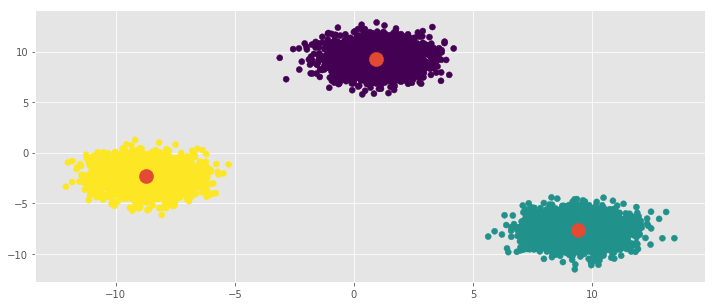

In [13]:
## Работоспособность KMeans
Kmeans_cython = KMeans_cython(k=3)
%timeit Kmeans_cython.fit(X)
y_test_KMeans = Kmeans_cython.predict(what='y')
C_test_KMeans = Kmeans_cython.predict(what='centroids')


plt.scatter(X[:,0], X[:,1], c=y_test_KMeans)
plt.scatter(C_test_KMeans[:,0], C_test_KMeans[:,1], s=200)
plt.show()

## Проверка на реальных данных:

In [14]:
import pandas as pd
df_sns = pd.read_csv('snsdata.csv', sep=',').dropna()
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2006,F,18.930,72,0,0,0,0,0,0,...,0,2,0,0,2,0,0,0,0,0


In [15]:
#извлекаем матрицу признаков
df = df_sns.loc[:,'basketball':'drugs'].as_matrix()
df.shape
#нормализуем
df = (df - df.mean(axis=0))/df.std(axis=0)
df

array([[-0.33957553, -0.36936768, -0.2455023 , ..., -0.27017065,
        -0.22425649, -0.1770471 ],
       [-0.33957553,  1.01800067, -0.2455023 , ..., -0.27017065,
        -0.22425649, -0.1770471 ],
       [-0.33957553,  1.01800067, -0.2455023 , ...,  2.00223527,
        -0.22425649, -0.1770471 ],
       ..., 
       [-0.33957553,  1.01800067, -0.2455023 , ..., -0.27017065,
        -0.22425649, -0.1770471 ],
       [-0.33957553, -0.36936768, -0.2455023 , ..., -0.27017065,
        -0.22425649, -0.1770471 ],
       [ 2.11643849, -0.36936768, -0.2455023 , ..., -0.27017065,
        -0.22425649, -0.1770471 ]])

In [16]:
stud_KMeans_cdist = KMeans_cdist(k=9, max_iter=10)
%timeit stud_KMeans_cdist.fit(df)

10 loops, best of 3: 123 ms per loop


In [17]:
stud_KMeans_python = KMeans_python(k=9, max_iter=10)
%timeit stud_KMeans_python.fit(df)

1 loop, best of 3: 508 ms per loop


In [18]:
stud_KMeans_cython = KMeans_cython(k=9, max_iter=10)
%timeit stud_KMeans_cython.fit(df)

1 loop, best of 3: 250 ms per loop


### Выводы:

Судя по профайлеру, самой затратной операцией является нахождение матрицы расстояний между точками и центроидами. Функция cdist из Scipy и функция, реализованная на Cython работают практически с одинаковой скоростью. Эта же функция, реализованная через Numpy работает примерно в два раза медленнее. Еще одной трудоемкой операцией является перераспределение кластеров на основе новой классификации точек. Ее также можно оптимизировать с помощью Cython. Расчет на реальных данных показал, что Cython имеет преимущество перед голым Python с Numpy, но в некоторых случаях, использование специальных библиотек является более эффективным. На тестовых же данных при помощи cdist достигается ускорение в два раза и еще в два раза для Cython.